In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [57]:
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, cross_val_score
from sklearn.preprocessing import LabelEncoder

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [64]:
import os

def pretraitement_knn():
    start_time = datetime.now()
    pathfile = r'data_anonymous/'

    # reflist: list of epc in each box
    reflist = pd.DataFrame()
    # 
    files=os.listdir(pathfile)
    for file in files:
        if file.startswith('reflist_'):
            temp=pd.read_csv(os.path.join(pathfile,file),sep=',').reset_index(drop=True)[['Epc']]
            temp['refListId']=file.split('.')[0]
            reflist = pd.concat([reflist, temp], axis = 0)
            #reflist=reflist.append(temp)
    reflist=reflist.rename(columns = {'refListId':'refListId_actual'})
    reflist['refListId_actual'] = reflist['refListId_actual'].apply(lambda x:int(x[8:]))

    Q_refListId_actual=reflist.groupby('refListId_actual')['Epc'].nunique().rename('Q refListId_actual').reset_index(drop=False)
    reflist=pd.merge(reflist,Q_refListId_actual,on='refListId_actual',how='left')
    
    df=pd.DataFrame()
    # 
    #files=os.listdir(pathfile)
    for file in files:
        if file.startswith('ano_APTags'):
       
            temp=pd.read_csv(os.path.join(pathfile,file),sep=',')
            df= pd.concat([df, temp], axis = 0)
    df['LogTime'] = pd.to_datetime (df['LogTime'] ,format='%Y-%m-%d-%H:%M:%S') 
    df['TimeStamp'] = df['TimeStamp'].astype(float)
    df['Rssi'] = df['Rssi'].astype(float)
    df=df.drop(['Reader','EmitPower','Frequency'],axis=1).reset_index(drop=True)
    df=df[['LogTime', 'Epc', 'Rssi', 'Ant']]
    # antennas 1 and 2 are facing the box when photocell in/out 
    Ant_loc=pd.DataFrame({'Ant':[1,2,3,4],'loc':['in','in','out','out']})
    df=pd.merge(df,Ant_loc,on=['Ant'])
    df=df.sort_values('LogTime').reset_index(drop=True)

    tags = df

        # timing: photocells a time window for each box: start/stop (ciuchStart, ciuchStop)
    file=r'ano_supply-process.2019-11-07-CUT.csv'
    timing=pd.read_csv(os.path.join(pathfile,file),sep=',')
    timing['file']=file
    timing['date']=pd.to_datetime(timing['date'],format='%d/%m/%Y %H:%M:%S,%f')
    timing['ciuchStart']=pd.to_datetime(timing['ciuchStart'],format='%d/%m/%Y %H:%M:%S,%f')
    timing['ciuchStop']=pd.to_datetime(timing['ciuchStop'],format='%d/%m/%Y %H:%M:%S,%f')
    timing['timestampStart']=timing['timestampStart'].astype(float)
    timing['timestampStop']=timing['timestampStop'].astype(float)
    timing=timing.sort_values('date')
    timing.loc[:,'refListId']=timing.loc[:,'refListId'].apply(lambda x:int(x[8:]))
    timing=timing[['refListId', 'ciuchStart', 'ciuchStop']]
    
    
        # ciuchStart_up starts upstream ciuchStart, half way in between the previous stop and the actual start
    timing[['ciuchStop_last']]=timing[['ciuchStop']].shift(1)
    timing[['refListId_last']]=timing[['refListId']].shift(1)
    timing['ciuchStartup']=timing['ciuchStart'] - (timing['ciuchStart'] - timing['ciuchStop_last'])/2
    # timing start: 10sec before timing
    timing.loc[0,'refListId_last']=timing.loc[0,'refListId']
    timing.loc[0,'ciuchStartup']=timing.loc[0,'ciuchStart']-datetime.timedelta(seconds=10)
    timing.loc[0,'ciuchStop_last']=timing.loc[0,'ciuchStartup']-datetime.timedelta(seconds=10)
    timing['refListId_last']=timing['refListId_last'].astype(int)
    # 
    timing['ciuchStopdown']= timing['ciuchStartup'].shift(-1)
    timing.loc[len(timing)-1,'ciuchStopdown']=timing.loc[len(timing)-1,'ciuchStop']+datetime.timedelta(seconds=10)
    timing=timing[['refListId', 'refListId_last','ciuchStartup', 'ciuchStart','ciuchStop','ciuchStopdown']]
    
    
        # t0_run = a new run starts when box 0 shows up
    t0_run=timing[timing['refListId']==0] [['ciuchStartup']]
    t0_run=t0_run.rename(columns={'ciuchStartup':'t0_run'})
    t0_run=t0_run.groupby('t0_run').size().cumsum().rename('run').reset_index(drop=False)
    t0_run=t0_run.sort_values('t0_run')
    # 
    # each row in timing is merged with a last row in t0_run where t0_run (ciuchstart) <= timing (ciuchstart)
    timing=pd.merge_asof(timing,t0_run,left_on='ciuchStartup',right_on='t0_run', direction='backward')
    timing=timing.sort_values('ciuchStop')
    timing=timing[['run', 'refListId', 'refListId_last', 'ciuchStartup','ciuchStart','ciuchStop','ciuchStopdown','t0_run']]

    
    slices = pd.DataFrame()
    for i, row in timing.iterrows():
        ciuchStartup = row['ciuchStartup']
        ciuchStart = row['ciuchStart']
        ciuchStop = row['ciuchStop']
        ciuchStopdown = row['ciuchStopdown']
        steps = 3

        # Cr�ation des tranches "up"
        up = pd.DataFrame(index=pd.date_range(start=ciuchStartup, end=ciuchStart, periods=steps)) \
            .reset_index(drop=False).rename(columns={'index': 'slice'})
        up['slice_id'] = ['up_' + str(x) for x in range(steps)]
        slices = pd.concat([slices, up], ignore_index=True)

        # Cr�ation des tranches "mid"
        mid = pd.DataFrame(index=pd.date_range(start=ciuchStart, end=ciuchStop, periods=steps)) \
            .reset_index(drop=False).rename(columns={'index': 'slice'})
        mid['slice_id'] = ['mid_' + str(x) for x in range(steps)]
        slices = pd.concat([slices, mid], ignore_index=True)

        # Cr�ation des tranches "down"
        down = pd.DataFrame(index=pd.date_range(start=ciuchStop, end=ciuchStopdown, periods=steps)) \
            .reset_index(drop=False).rename(columns={'index': 'slice'})
        down['slice_id'] = ['down_' + str(x) for x in range(steps)]
        slices = pd.concat([slices, down], ignore_index=True)

    slices.reset_index(drop=False, inplace=True)

    # 
    timing_slices=pd.merge_asof(slices,timing,left_on='slice',right_on='ciuchStartup',direction='backward')
    timing_slices=timing_slices[['run', 'refListId', 'refListId_last','slice_id','slice',  \
                                 'ciuchStartup', 'ciuchStart', 'ciuchStop', 'ciuchStopdown','t0_run']]
    
    # merge between df and timing
    # merge_asof needs sorted df > df_ref
    df=df[ (df['LogTime']>=timing['ciuchStartup'].min()) & (df['LogTime']<=timing['ciuchStopdown'].max())  ]
    df=df.sort_values('LogTime')
    # 
    # each row in df_ref is merged with the last row in timing where timing (ciuchstart_up) < df_ref (logtime)
    # 
    # df_timing=pd.merge_asof(df_ref,timing,left_on=['LogTime'],right_on=['ciuchStartup'],direction='backward')
    # df_timing=df_timing.dropna()
    # df_timing=df_timing.sort_values('LogTime').reset_index(drop=True)
    # df_timing=df_timing[['run', 'Epc','refListId', 'refListId_last', 'ciuchStartup',\
    #                      'LogTime', 'ciuchStop', 'ciuchStopdown','Rssi', 'loc', 'refListId_actual']]
    # 
    # each row in df_ref is merged with the last row in timing_slices where timing (slice) < df_ref (logtime)
    # 
    df_timing_slices=pd.merge_asof(df,timing_slices,left_on=['LogTime'],right_on=['slice'],direction='backward')
    df_timing_slices=df_timing_slices.dropna()
    df_timing_slices=df_timing_slices.sort_values('slice').reset_index(drop=True)
    df_timing_slices=df_timing_slices[['run', 'Epc','refListId', 'refListId_last', 'ciuchStartup','slice_id','slice','LogTime', \
                          'ciuchStart','ciuchStop', 'ciuchStopdown', 'Rssi', 'loc','t0_run']]
    df_timing_slices['reflist_run_id'] = df_timing_slices['refListId'].astype(str) +"_"+ df_timing_slices['run'].astype(str)
    
    # runs 16 23 32 40 have missing boxes: discarded
    # also run 1 is the start, no previous box: discarded
    # run 18: box 0 run at the end
    # 
    timing=timing[~timing['run'].isin([1,18,16,23,32,40])]
    timing_slices=timing_slices[~timing_slices['run'].isin([1,18,16,23,32,40])]
    df_timing_slices=df_timing_slices[~df_timing_slices['run'].isin([1,18,16,23,32,40])]

    df_timing_slices=df_timing_slices.sort_values(['LogTime','Epc'])
    
    # df_timing_slices['dt']=
    df_timing_slices['dt']=(df_timing_slices['LogTime']-df_timing_slices['t0_run']).apply(lambda x:x.total_seconds())
    
    timing['reflist_run_id']= timing['refListId'].astype(str)+"_"+ timing['run'].astype(str)
    timing['window_width']=(timing['ciuchStopdown']-timing['ciuchStartup']).apply(lambda x:x.total_seconds())
    windows=timing[['reflist_run_id', 'window_width']]
    rssi_quantite=1
    return [df_timing_slices, windows,rssi_quantite,reflist]


def dataset(df_timing_slices, windows, rssi_quantite):
    ds_rssi = df_timing_slices.groupby(['Epc', 'reflist_run_id', 'slice_id', 'loc'])['Rssi'].quantile(rssi_quantite) \
                 .unstack(['slice_id', 'loc'], fill_value=-110)
    ds_rssi.columns = [x[0] + '_' + x[1] for x in ds_rssi.columns]
    ds_rssi = ds_rssi.reset_index(drop=False)
    
    ds_rc = df_timing_slices.groupby(['Epc', 'reflist_run_id', 'slice_id', 'loc']).size() \
               .unstack(['slice_id', 'loc'], fill_value=0)
    ds_rc.columns = [x[0] + '_' + x[1] for x in ds_rc.columns]
    ds_rc = ds_rc.reset_index(drop=False)
    
    ds = pd.merge(ds_rssi, ds_rc, on=['Epc', 'reflist_run_id'], suffixes=['_rssi', '_rc'])
    ds = pd.merge(ds, windows, on='reflist_run_id', how='left')
    
    Q_Epcs_window = df_timing_slices.groupby(['reflist_run_id'])['Epc'].nunique().rename('Epcs_window').reset_index(drop=False)
    ds = pd.merge(ds, Q_Epcs_window, on='reflist_run_id', how='left')
    
    Q_reads_window = df_timing_slices.groupby(['reflist_run_id']).size().rename('reads_window').reset_index(drop=False)
    ds = pd.merge(ds, Q_reads_window, on='reflist_run_id', how='left')
    
    ds=pd.merge(ds, pretraitement_knn()[3], on='Epc', how='left')
    ds['actual']=ds['reflist_run_id'].apply(lambda x: x.split ('_')[0]).astype('int64')== ds['refListId_actual']
    ds['actual'] = ds ['actual'].replace({True: 'IN' , False: 'OUT'})
    
    end_time = datetime.now()
    print('Duree de pretraitement_knn {}'.format(end_time - start_time))
    
    return ds
#data = pretraitement_knn()
#colonne=dataset(pretraitement_knn()[0],pretraitement_knn()[1],pretraitement_knn()[2]).columns


def Xcols_func(features, Xcols_all):
    Features=pd.DataFrame(\
        [\
         ['all', True, True, False, True, True, True],\
         ['rssi & rc only', True, True, False, False, False, False],\
         ['rssi & rc_mid', True, True, True, False, False, False],\
         ['rssi only', True, False, True, False, False, False],\
         ['rc only', False, True, False, False, False, False],\
        ], columns=['features', 'rssi', 'rc', 'rc_mid_only', 'Epcs_window', 'reads_window', 'window_width'])
    Features

    Features_temp = Features[Features['features']==features]
    
    X=[]
    rssi = Features_temp ['rssi'].values[0]
    rc = Features_temp['rc'].values[0]
    rc_mid_only = Features_temp['rc_mid_only'].values[0]
    Epcs_window =  Features_temp['Epcs_window'].values[0]
    reads_window =  Features_temp['reads_window'].values[0]
    window_width =  Features_temp['window_width'].values[0]
    
    colonne = Xcols_all
    
    X_rssi = [x for x in colonne if rssi*'rssi' in x.split('_')]
    X_rc = [x for x in colonne if rc*'rc' in x.split('_')]
    
    X = X_rssi + X_rc
    
    if Epcs_window:
        X.append('Epcs_window')
    if reads_window:
        X.append('reads_window')
    if window_width:
        X.append('window_width')
        
    return X

In [13]:
estimators = list(range(1,90))
depth = list(range(1,50))
leaves = list(range(1,30))

In [25]:
neighbors = list(range(1,100))
weights = ["uniform", "distance"]
metrics = ["minkowski", "euclidean", "manhattan"]

In [26]:
C =  [ round(x * 0.02, 3) for x in range(50)] + [round(x * 0.2, 3) for x in range(5,51)]
gammas = ['scale', 'auto']
kernels = ['rbf','linear','polynomial', 'precomputed', 'sygmoid']

In [30]:
rf, svm, knn = RandomForestClassifier(), SVC(), KNeighborsClassifier()

In [ ]:
{
    "random forest":["n_estimators", "max_depth", "min_samples_leaf"],
    "SVM" : ["gamma", "c", "kernel"],
    "KNN" : ["n_neighors","weight", "metric" ]
}

In [42]:
label_encoder = LabelEncoder()

In [44]:
# Getting the data
data = pretraitement_knn() 
ds = dataset(data[0],data[1],data[2])

In [45]:
# Getting X and y 
X = ds[Xcols_func('rssi & rc only',ds.columns)]
ds['actual'] = label_encoder.fit_transform(ds['actual'])
y = ds['actual']

C:\Users\pc\AppData\Local\Temp\ipykernel_17196\859919143.py:212: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  X_rssi = [x for x in colonne if rssi*'rssi' in x.split('_')]
C:\Users\pc\AppData\Local\Temp\ipykernel_17196\859919143.py:213: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  X_rc = [x for x in colonne if rc*'rc' in x.split('_')]


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [61]:
train_scores, val_scores = validation_curve(rf, X_train, y_train, param_name = 'n_estimators',
                                            param_range = np.array(neighbors), cv = 7)

In [79]:
def plot_validation_curves(ml_model:str, train_X, train_y, hyper_parameter:str, parameter_range, 
                           folders:int):
    start = datetime.now()
    models = { 
        'RandomForest': RandomForestClassifier(), 
       # 'Random Forest' : RandomForestClassifier(), 
        'SVM' : SVC(),
        'KNN' : KNeighborsClassifier(),
       # 'Kneigbors' : KNeighborsClassifier()
    }
    
    train_scores, val_scores = validation_curve(models[ml_model], train_X, train_y, param_name = hyper_parameter,
                                                     param_range = np.array(parameter_range), cv = folders)
    
    # curves 
    plt.plot(parameter_range, train_scores, 'y-', label = "score à l\'entrainement")
    #plt.plot(parameter_range, val_scores, 'r-', label = "score à la validation")
     
    # Ajouter un titre et des légendes pour l'axe x et l'axe y
    plt.title('Précision de '+ ml_model + 'en fonction de ' + hyper_parameter ) # titre
    plt.xlabel('Valeurs de ' + hyper_parameter) # légende de l'axe des abscisses
    plt.ylabel('Valeurs de précision') # légende de l'axe des ordonées
    
    # légende
    plt.legend() 
    plt.grid(True)
    
    # Sauvegarde des graphes
    plt.savefig('courbes/' + ml_model + '/' + hyper_parameter + '.png', dpi = 300)
    
    #print('min22 :',df_month['value22'].max(),'\nMin23 :', df_month['value23'].max())
    plt.show() # Affichage de la figure
    end = datetime.now()
    print('Duree de curve_validation_plot : {}'.format(end-start))
    

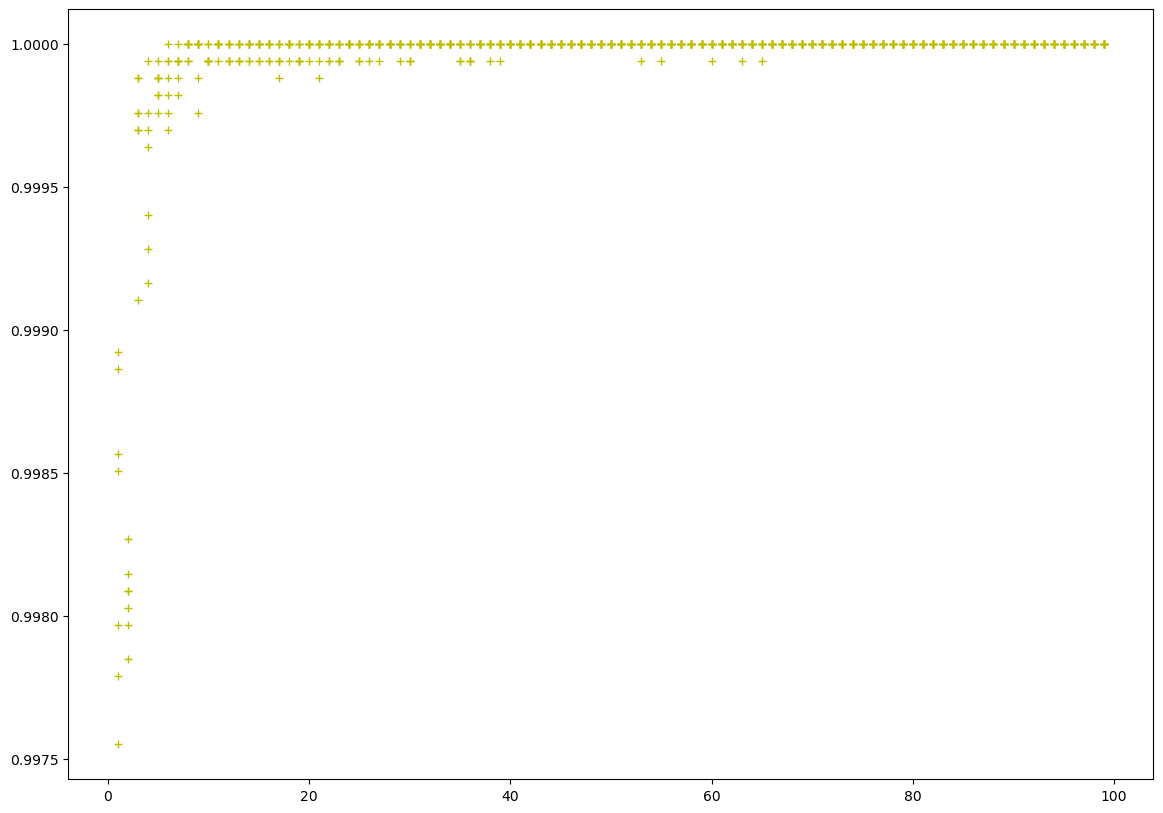

In [74]:
plt.figure(figsize = (14,10))
plt.plot(np.array(neighbors), train_scores, 'y+', label = "score à l\'entrainement")
#plt.plot(np.array(neighbors), val_scores, 'r-', label = "score à la validation")
plt.show()

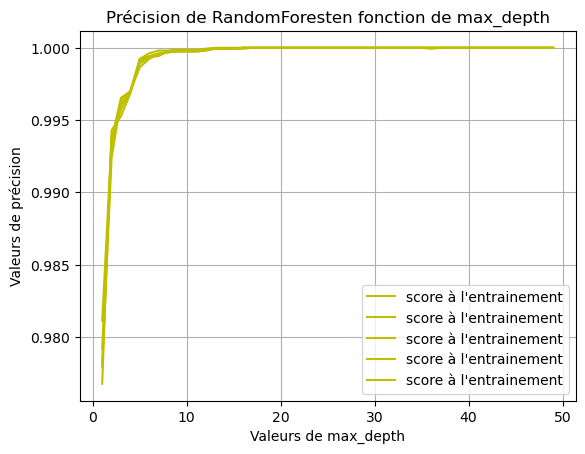

Duree de curve_validation_plot : 0:04:30.290581


In [83]:
plot_validation_curves('RandomForest',X_train, y_train, 'max_depth', depth, 5)